In [101]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [102]:
import torch
from torch import nn, optim
from torch.nn import functional as F

from pathlib import Path
from functools import partial
import matplotlib.pyplot as plt

from exp.nb_XLibrary import *

In [66]:
from fastai import datasets as FAdataset
import os
import sys
import mimetypes
from collections import OrderedDict

# Setup paths and get data

In [4]:
FAdataset.URLs.IMAGENETTE_160

'https://s3.amazonaws.com/fast-ai-imageclas/imagenette-160'

In [5]:
home_dir = Path('.').resolve()
data_dir = home_dir/'data'
home_dir, data_dir

(PosixPath('/Users/xianli/Desktop/fast/Part2'),
 PosixPath('/Users/xianli/Desktop/fast/Part2/data'))

In [6]:
file_path = FAdataset.untar_data(FAdataset.URLs.IMAGENETTE_160,dest=data_dir)
file_path

PosixPath('/Users/xianli/Desktop/fast/Part2/data/imagenette-160')

Monkey-patch the Path class with a `.ls` method

In [7]:
#export
Path.ls = lambda x: list(x.iterdir())

In [8]:
(file_path/'val').ls()

[PosixPath('/Users/xianli/Desktop/fast/Part2/data/imagenette-160/val/n03394916'),
 PosixPath('/Users/xianli/Desktop/fast/Part2/data/imagenette-160/val/n03417042'),
 PosixPath('/Users/xianli/Desktop/fast/Part2/data/imagenette-160/val/n03445777'),
 PosixPath('/Users/xianli/Desktop/fast/Part2/data/imagenette-160/val/n02102040'),
 PosixPath('/Users/xianli/Desktop/fast/Part2/data/imagenette-160/val/n03425413'),
 PosixPath('/Users/xianli/Desktop/fast/Part2/data/imagenette-160/val/n03888257'),
 PosixPath('/Users/xianli/Desktop/fast/Part2/data/imagenette-160/val/n03028079'),
 PosixPath('/Users/xianli/Desktop/fast/Part2/data/imagenette-160/val/n03000684'),
 PosixPath('/Users/xianli/Desktop/fast/Part2/data/imagenette-160/val/n01440764'),
 PosixPath('/Users/xianli/Desktop/fast/Part2/data/imagenette-160/val/n02979186')]

look at a few images inside the folder

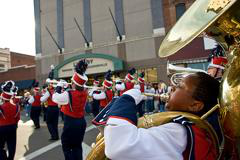

In [9]:
path1 = file_path/'val'/'n03394916'
img_file = path1.ls()[1]

import PIL
PIL.Image.open(img_file)

In [10]:
import mimetypes
image_extensions = set(k for k,v in mimetypes.types_map.items() if v.startswith('image/'))
image_extensions

{'.bmp',
 '.gif',
 '.ico',
 '.ief',
 '.jpe',
 '.jpeg',
 '.jpg',
 '.pbm',
 '.pgm',
 '.png',
 '.pnm',
 '.ppm',
 '.ras',
 '.rgb',
 '.svg',
 '.tif',
 '.tiff',
 '.xbm',
 '.xpm',
 '.xwd'}

In [11]:
setify(['aa','b'])

{'aa', 'b'}

# get all files in all directories

In [12]:
#export
# this function gets all the fnames within a given directory,
# excluding hidden files that starts with '.'
# include all files when an extension is not given
# or if extensions is given, if the given ones is within our target extension list
# NOTE: the extensions need to start with a '.', e.g. '.jpg'
def _get_files(directory, fnames, extensions=None):
    p = Path(directory)
    res = [p/f for f in fnames if not f.startswith('.')
          and ((not extensions) or f'.{f.split(".")[-1].lower()}' in extensions)]
    return res

In [13]:
t = [o.name for o in os.scandir(path1)]
t = _get_files(file_path,t,extensions=image_extensions)
len(t), t[:3]

(50,
 [PosixPath('/Users/xianli/Desktop/fast/Part2/data/imagenette-160/ILSVRC2012_val_00046669.JPEG'),
  PosixPath('/Users/xianli/Desktop/fast/Part2/data/imagenette-160/ILSVRC2012_val_00033682.JPEG'),
  PosixPath('/Users/xianli/Desktop/fast/Part2/data/imagenette-160/ILSVRC2012_val_00005548.JPEG')])

In [14]:
list(os.walk(file_path))

[('/Users/xianli/Desktop/fast/Part2/data/imagenette-160',
  ['train', 'val'],
  []),
 ('/Users/xianli/Desktop/fast/Part2/data/imagenette-160/train',
  ['n03394916',
   'n03417042',
   'n03445777',
   'n02102040',
   'n03425413',
   'n03888257',
   'n03028079',
   'n03000684',
   'n01440764',
   'n02979186'],
  []),
 ('/Users/xianli/Desktop/fast/Part2/data/imagenette-160/train/n03394916',
  [],
  ['n03394916_58454.JPEG',
   'n03394916_32588.JPEG',
   'n03394916_32422.JPEG',
   'n03394916_33663.JPEG',
   'n03394916_27948.JPEG',
   'n03394916_38644.JPEG',
   'n03394916_35076.JPEG',
   'n03394916_38214.JPEG',
   'n03394916_23008.JPEG',
   'n03394916_33008.JPEG',
   'n03394916_7606.JPEG',
   'n03394916_35133.JPEG',
   'n03394916_28428.JPEG',
   'n03394916_53473.JPEG',
   'n03394916_28994.JPEG',
   'n03394916_69132.JPEG',
   'n03394916_33771.JPEG',
   'n03394916_44089.JPEG',
   'n03394916_29940.JPEG',
   'n03394916_11495.JPEG',
   'n03394916_40160.JPEG',
   'n03394916_29106.JPEG',
   'n03394

In [15]:
#export
# this function walk through all directory and return all files
def get_files(path, extensions=None, recurse=False, include=None):
    # include = None == include all
    path = Path(path) # pathlib is easier to use
    extensions = setify(extensions) # remove duplicates
    extensions = {e.lower() for e in extensions} # lowercased
    if recurse:
        res = []
        for i, (p,d,f) in enumerate(os.walk(path)): # returns (dirpath, folder names, filenames)
            # each iteration this goes a layer deeper into sub-directories
            if include is not None and i==0:
                d[:] = [o for o in d if o in include] # include some folders, not all
            else:
                d[:] = [o for o in d if not o.startswith('.')] # include all folders except the hidden ones
            res += _get_files(p,f,extensions)
        return res
    else:
        f = [o.name for o in os.scandir(path) if o.is_file()]
        return _get_files(path, f, extensions)

In [16]:
f = get_files(path1, image_extensions)
len(f)

50

In [17]:
all_fnames = get_files(file_path, image_extensions, recurse=True)
len(all_fnames)

13394

In [18]:
%timeit -n 10 get_files(file_path, image_extensions, recurse=True)

71.1 ms ± 2.37 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


# To do summary
What we need to do:

- Get files
- Split validation set
  - random%, folder name, csv, ...
- Label: 
  - folder name, file name/re, csv, ...
- Transform per image (optional)
- Transform to tensor
- DataLoader
- Transform per batch (optional)
- DataBunch
- Add test set (optional)

In [19]:
#export
# apply several functions to data x and replace x in place
def compose(x, funcs, *args, order_key='_order', **kwargs):
    key = lambda o: getattr(o, order_key, 0)
    for f in sorted(listify(funcs), key=key):
        x = f(x, **kwargs)
    return x

store our objects in an `ItemList`. The `get` method will need to be subclassed to explain how to access an element (open an image for instance), then the private `_get` method can allow us to apply any additional transform to it.

`new` will be used in conjunction with `__getitem__` (that works for one index or a list of indices) to create training and validation set from a single stream when we split the data.

In [20]:
#export
class ItemList(ListContainer):
    def __init__(self, items, path='.', tfms=None):
        super().__init__(items) # the list of objects can be subscripted like a numpy array
        self.path, self.tfms = Path(path), tfms
    
    def __repr__(self):
        return f'{super().__repr__()}\nPath: {self.path}' # print out list objects and the related path
    
    def new(self, items, cls=None): # create a new cls-class object 
        if cls is None:
            cls = self.__class__
        return cls(items, self.path, tfms=self.tfms)
    
    def get(self, i): # this method needs to be overloaded by subclasses to explain how to access an element
        return i
    
    def _get(self, i): # apply transforms to item i
        return compose(self.get(i), self.tfms) 
    
    def __getitem__(self, idx): # apply transform and then return
        res = super().__getitem__(idx)
        if isinstance(res, list):
            return [self._get(o) for o in res]
        return self._get(res)

def get_image_extensions():
    return set(k for k,v in mimetypes.types_map.items() if v.startswith('image/'))

In [21]:
#export
# for image application only
class ImageList(ItemList): # inherent ItemList methods
    @classmethod # this is to be called directly by class name
    def from_files(cls, path, extensions=None, recurse=True, include=None, **kwargs):
        if extensions is None:
            extensions = get_image_extensions()
        return cls(get_files(path, extensions, recurse=recurse, include=include), path, **kwargs)
    
    def get(self, fname): # overload the parent class get to show how to access elements
        return PIL.Image.open(fname)
    

In [22]:
#export
class Transform(): _order=0

class MakeRGB(Transform):
    def __call__(self, item): return item.convert('RGB')

def make_rgb(item): return item.convert('RGB')

In [23]:
il = ImageList.from_files(file_path, tfms=make_rgb)
il

ImageList (13394 items)
[PosixPath('/Users/xianli/Desktop/fast/Part2/data/imagenette-160/train/n03394916/n03394916_58454.JPEG'), PosixPath('/Users/xianli/Desktop/fast/Part2/data/imagenette-160/train/n03394916/n03394916_32588.JPEG'), PosixPath('/Users/xianli/Desktop/fast/Part2/data/imagenette-160/train/n03394916/n03394916_32422.JPEG'), PosixPath('/Users/xianli/Desktop/fast/Part2/data/imagenette-160/train/n03394916/n03394916_33663.JPEG'), PosixPath('/Users/xianli/Desktop/fast/Part2/data/imagenette-160/train/n03394916/n03394916_27948.JPEG'), PosixPath('/Users/xianli/Desktop/fast/Part2/data/imagenette-160/train/n03394916/n03394916_38644.JPEG'), PosixPath('/Users/xianli/Desktop/fast/Part2/data/imagenette-160/train/n03394916/n03394916_35076.JPEG'), PosixPath('/Users/xianli/Desktop/fast/Part2/data/imagenette-160/train/n03394916/n03394916_38214.JPEG'), PosixPath('/Users/xianli/Desktop/fast/Part2/data/imagenette-160/train/n03394916/n03394916_23008.JPEG'), PosixPath('/Users/xianli/Desktop/fast/P

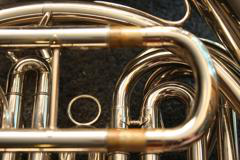

In [24]:
img = il[0]; img

In [25]:
il[:1]

[<PIL.Image.Image image mode=RGB size=240x160 at 0x10E3A54E0>]

## Split validation set by folder name

In [26]:
fn = il.items[0]
fn

PosixPath('/Users/xianli/Desktop/fast/Part2/data/imagenette-160/train/n03394916/n03394916_58454.JPEG')

In [27]:
fn.parent.parent.name

'train'

In [28]:
#export
def split_by_func(items, f):
    mask = [f(o) for o in items]
    # `None` values will be filtered out
    f = [o for o,m in zip(items, mask) if m==False] # the False set by given criterion f
    t = [o for o,m in zip(items, mask) if m==True] # the True set
    return f, t 

In [29]:
#export
def grandparent_splitter(fn, valid_name='valid', train_name='train'):
    # return boolean masks for a single item split by folder name at the grandparent level of path
    gp = fn.parent.parent.name # define grandparent
    return True if gp==valid_name else False if gp==train_name else None

# usage example
#splitter = partial(grandparent_splitter, valid_name='val')

In [30]:
splitter = partial(grandparent_splitter, valid_name='val')

In [31]:
%time train,valid = split_by_func(il, splitter)

CPU times: user 31.9 ms, sys: 1.13 ms, total: 33.1 ms
Wall time: 32.7 ms


In [32]:
len(train), len(valid)

(12894, 500)

class to perform and contain the split data

In [33]:
#export
class SplitData():
    def __init__(self, train, valid): # to be init by class method
        self.train = train # this is a class object with same class as given
        self.valid = valid
    
    def __getattr__(self, k): #
        return getattr(self.train, k) # to be handled by the class that train object belongs to
    
    #This is needed if we want to pickle SplitData and be able to load it back without recursion errors
    def __setstate__(self,data):
        self.__dict__.update(data)
    
    def __repr__(self): return f'{self.__class__.__name__}\nTrain: {self.train}\nValid: {self.valid}\n'
    
    @classmethod
    def split_by_func(cls, il, f):
        lists = map(il.new, split_by_func(il.items, f)) # il needs to have a new method
        return cls(*lists) # fed into __init__
# usage example:
#sd = SplitData.split_by_func(il, splitter)

In [34]:
sd = SplitData.split_by_func(il, splitter); sd

SplitData
Train: ImageList (12894 items)
[PosixPath('/Users/xianli/Desktop/fast/Part2/data/imagenette-160/train/n03394916/n03394916_58454.JPEG'), PosixPath('/Users/xianli/Desktop/fast/Part2/data/imagenette-160/train/n03394916/n03394916_32588.JPEG'), PosixPath('/Users/xianli/Desktop/fast/Part2/data/imagenette-160/train/n03394916/n03394916_32422.JPEG'), PosixPath('/Users/xianli/Desktop/fast/Part2/data/imagenette-160/train/n03394916/n03394916_33663.JPEG'), PosixPath('/Users/xianli/Desktop/fast/Part2/data/imagenette-160/train/n03394916/n03394916_27948.JPEG'), PosixPath('/Users/xianli/Desktop/fast/Part2/data/imagenette-160/train/n03394916/n03394916_38644.JPEG'), PosixPath('/Users/xianli/Desktop/fast/Part2/data/imagenette-160/train/n03394916/n03394916_35076.JPEG'), PosixPath('/Users/xianli/Desktop/fast/Part2/data/imagenette-160/train/n03394916/n03394916_38214.JPEG'), PosixPath('/Users/xianli/Desktop/fast/Part2/data/imagenette-160/train/n03394916/n03394916_23008.JPEG'), PosixPath('/Users/xian

# Labeling

Labeling has to be done *after* splitting, because it uses *training* set information to apply to the *validation* set, using a *Processor*.

A *Processor* is a transformation that is applied to all the inputs once at initialization, with some *state* computed on the training set that is then applied without modification on the validation set (and maybe the test set or at inference time on a single item). For instance, it could be **processing texts** to **tokenize**, then **numericalize** them. In that case we want the validation set to be numericalized with exactly the same vocabulary as the training set.

Another example is in **tabular data**, where we **fill missing values** with (for instance) the median computed on the training set. That statistic is stored in the inner state of the *Processor* and applied on the validation set.

In our case, we want to **convert label strings to numbers** in a consistent and reproducible way. So we create a list of possible labels in the training set, and then convert our labels to numbers based on this *vocab*.

In [40]:
#export
def uniqueify(x, sort=False): 
    # turn a list into a list with unique elements
    # and keep the ORDER of the elements unchanged
    res = list(OrderedDict.fromkeys(x).keys()) # orderDict will only keep unique keys
    if sort: res.sort()
    return res

In [44]:
a = [1,3,3,2,4,2,1]
%time b = list(OrderedDict.fromkeys(a).keys())
%time c = list(set(a))
b, c

CPU times: user 7 µs, sys: 0 ns, total: 7 µs
Wall time: 9.06 µs
CPU times: user 4 µs, sys: 1e+03 ns, total: 5 µs
Wall time: 5.01 µs


([1, 3, 2, 4], [1, 2, 3, 4])

## Processors

In [46]:
#export
class Processor():
    def process(self,items): return items

class CategoryProcessor(Processor):
    def __init__(self):
        self.vocab = None
    
    def __call__(self, items):
        #The vocab is defined on the first use.
        if self.vocab is None: # build vocab and reverse dict
            self.vocab = uniqueify(items) # it's a list
            self.otoi = {v:k for k,v in enumerate(self.vocab)} # reverse dict
        return [self.proc1(o) for o in items] # return indices of vocab
    
    def proc1(self,item): 
        return self.otoi[item]

    def deprocess(self,idxs):
        assert self.vocab is not None
        return [self.deproc1(i) for i in idxs]
    
    def deproc1(self,idx): return self.vocab[idx]
    

# Label by folder name using processors

In [47]:
#export
# label by parent folder name
def parent_labeler(fn): return fn.parent.name

def _label_by_func(ds, f, cls=ItemList):
    return cls([f(o) for o in ds.items], path = ds.path) # create ItemList object

class LabeledData():
    def process(self, il, proc): # use ItemList method
        # apply process proc to data and return ItemList objects
        return il.new(compose(il.items,proc))
    
    def __init__(self,x,y,proc_x=None,proc_y=None):
        self.x = self.process(x,proc_x)
        self.y = self.process(y,proc_y)
        self.proc_x = proc_x
        self.proc_y = proc_y
    
    def __repr__(self):
        return f'{self.__class__.__name__}\nx: {self.x}\ny: {self.y}\n'
    def __getitem__(self,idx):
        return self.x[idx], self.y[idx]
    def __len__(self): return len(self.x)
    
    def x_obj(self,idx): return self.obj(self.x, idx, self.proc_x)
    def y_obj(self,idx): return self.obj(self.y, idx, self.proc_y)
    
    def obj(self,items,idx,procs):
        isint = isinstance(idx,int) or (isinstance(idx,torch.LongTensor) and not idx.ndim) # int or tensor index
        item = items[idx]
        for proc in reversed(listify(procs)):
            item = proc.deproc1(item) if isint else proc.deprocess(item) # if item is a list
        return item
    
    @classmethod # this is the important method to use in practice
    def label_by_func(cls, il, f, proc_x=None, proc_y=None):
        return cls(il, _label_by_func(il, f), proc_x=proc_x,proc_y=proc_y)  
 

In [48]:
#export
# use the above class, take SplitData object and return SplitData object
def label_by_func(sd, f, proc_x=None, proc_y=None):
    train = LabeledData.label_by_func(sd.train, f, proc_x=proc_x, proc_y=proc_y)
    # the vocab has been built after labeling the train set
    # so the validation set will just use the exisiting labels
    valid = LabeledData.label_by_func(sd.valid, f, proc_x=proc_x, proc_y=proc_y)
    return SplitData(train,valid)

# usage example:
# ll = label_by_func(sd, parent_labeler, proc_y=CategoryProcessor())

In [49]:
ll = label_by_func(sd, parent_labeler, proc_y=CategoryProcessor())

In [53]:
ll.train.y

ItemList (12894 items)
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0...]
Path: /Users/xianli/Desktop/fast/Part2/data/imagenette-160

In [54]:
ll.train.y.items[0], ll.train.y_obj(0), ll.train.y_obj(slice(2))

(0, 'n03394916', ['n03394916', 'n03394916'])

In [55]:
ll # now there is a x and y for each of the train/valid set

SplitData
Train: LabeledData
x: ImageList (12894 items)
[PosixPath('/Users/xianli/Desktop/fast/Part2/data/imagenette-160/train/n03394916/n03394916_58454.JPEG'), PosixPath('/Users/xianli/Desktop/fast/Part2/data/imagenette-160/train/n03394916/n03394916_32588.JPEG'), PosixPath('/Users/xianli/Desktop/fast/Part2/data/imagenette-160/train/n03394916/n03394916_32422.JPEG'), PosixPath('/Users/xianli/Desktop/fast/Part2/data/imagenette-160/train/n03394916/n03394916_33663.JPEG'), PosixPath('/Users/xianli/Desktop/fast/Part2/data/imagenette-160/train/n03394916/n03394916_27948.JPEG'), PosixPath('/Users/xianli/Desktop/fast/Part2/data/imagenette-160/train/n03394916/n03394916_38644.JPEG'), PosixPath('/Users/xianli/Desktop/fast/Part2/data/imagenette-160/train/n03394916/n03394916_35076.JPEG'), PosixPath('/Users/xianli/Desktop/fast/Part2/data/imagenette-160/train/n03394916/n03394916_38214.JPEG'), PosixPath('/Users/xianli/Desktop/fast/Part2/data/imagenette-160/train/n03394916/n03394916_23008.JPEG'), PosixPa

# Transform to tensors

In [56]:
ll.train[0] # image and the label

(<PIL.Image.Image image mode=RGB size=240x160 at 0x1A2B650C18>, 0)

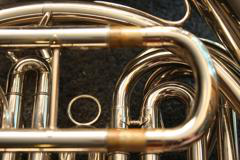

In [57]:
ll.train[0][0]

In [58]:
class ResizeFixed(Transform):
    _order=10
    def __init__(self,size):
        if isinstance(size,int): size=(size,size)
        self.size = size
        
    def __call__(self, item): return item.resize(self.size, PIL.Image.BILINEAR)

def to_byte_tensor(item):
    res = torch.ByteTensor(torch.ByteStorage.from_buffer(item.tobytes()))
    w,h = item.size
    return res.view(h,w,-1).permute(2,0,1)
to_byte_tensor._order=20

def to_float_tensor(item): return item.float().div_(255.)
to_float_tensor._order=30

## All pre-processing together

In [60]:
tfms = [make_rgb, ResizeFixed(128), to_byte_tensor, to_float_tensor]

splitter = partial(grandparent_splitter, valid_name='val')
il = ImageList.from_files(file_path, tfms=tfms)
sd = SplitData.split_by_func(il, splitter)
ll = label_by_func(sd, parent_labeler, proc_y=CategoryProcessor())

In [61]:
def show_image(im, figsize=(3,3)):
    plt.figure(figsize=figsize)
    plt.axis('off')
    plt.imshow(im.permute(1,2,0))

(torch.Size([3, 128, 128]), None)

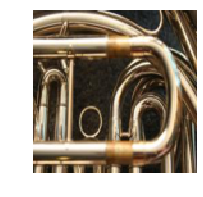

In [62]:
x, y = ll.train[0]
x.shape, show_image(x)

In [63]:
ll.train

LabeledData
x: ImageList (12894 items)
[PosixPath('/Users/xianli/Desktop/fast/Part2/data/imagenette-160/train/n03394916/n03394916_58454.JPEG'), PosixPath('/Users/xianli/Desktop/fast/Part2/data/imagenette-160/train/n03394916/n03394916_32588.JPEG'), PosixPath('/Users/xianli/Desktop/fast/Part2/data/imagenette-160/train/n03394916/n03394916_32422.JPEG'), PosixPath('/Users/xianli/Desktop/fast/Part2/data/imagenette-160/train/n03394916/n03394916_33663.JPEG'), PosixPath('/Users/xianli/Desktop/fast/Part2/data/imagenette-160/train/n03394916/n03394916_27948.JPEG'), PosixPath('/Users/xianli/Desktop/fast/Part2/data/imagenette-160/train/n03394916/n03394916_38644.JPEG'), PosixPath('/Users/xianli/Desktop/fast/Part2/data/imagenette-160/train/n03394916/n03394916_35076.JPEG'), PosixPath('/Users/xianli/Desktop/fast/Part2/data/imagenette-160/train/n03394916/n03394916_38214.JPEG'), PosixPath('/Users/xianli/Desktop/fast/Part2/data/imagenette-160/train/n03394916/n03394916_23008.JPEG'), PosixPath('/Users/xianli

# Modeling

In [67]:
bs=64

In [68]:
# dataloaders --> batch data 
# all this does is generating a generator of data batch
# all the original properties of input data class will be kept
train_dl, valid_dl = get_dls(ll.train, ll.valid, bs, num_workers =1)

In [71]:
x, y = next(iter(train_dl))
x.shape, y.shape

(torch.Size([64, 3, 128, 128]), torch.Size([64]))

'n02102040'

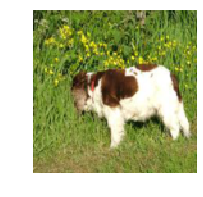

In [73]:
show_image(x[0])
ll.train.proc_y.vocab[y[0]] # the original label. proc_y is Categorical processor here


In [74]:
#export
class DataBunch(): # to hold all the data together, in dataloader form
    def __init__(self, train_dl, valid_dl, c_in=None, c_out=None):
        self.train_dl,self.valid_dl,self.c_in,self.c_out = train_dl,valid_dl,c_in,c_out

    @property
    def train_ds(self): return self.train_dl.dataset

    @property
    def valid_ds(self): return self.valid_dl.dataset

In [75]:
#export
def databunchify(sd, bs, c_in=None, c_out=None, **kwargs):
    dls = get_dls(sd.train, sd.valid, bs, **kwargs)
    return DataBunch(*dls, c_in=c_in, c_out=c_out)

SplitData.to_databunch = databunchify

In [76]:
# summary
tfms = [make_rgb, ResizeFixed(128), to_byte_tensor, to_float_tensor]

il = ImageList.from_files(file_path, tfms=tfms)
sd = SplitData.split_by_func(il, partial(grandparent_splitter, valid_name='val'))
ll = label_by_func(sd, parent_labeler, proc_y=CategoryProcessor())
data = ll.to_databunch(bs, c_in=3, c_out=10, num_workers=4) # 

In [78]:
data.train_ds

LabeledData
x: ImageList (12894 items)
[PosixPath('/Users/xianli/Desktop/fast/Part2/data/imagenette-160/train/n03394916/n03394916_58454.JPEG'), PosixPath('/Users/xianli/Desktop/fast/Part2/data/imagenette-160/train/n03394916/n03394916_32588.JPEG'), PosixPath('/Users/xianli/Desktop/fast/Part2/data/imagenette-160/train/n03394916/n03394916_32422.JPEG'), PosixPath('/Users/xianli/Desktop/fast/Part2/data/imagenette-160/train/n03394916/n03394916_33663.JPEG'), PosixPath('/Users/xianli/Desktop/fast/Part2/data/imagenette-160/train/n03394916/n03394916_27948.JPEG'), PosixPath('/Users/xianli/Desktop/fast/Part2/data/imagenette-160/train/n03394916/n03394916_38644.JPEG'), PosixPath('/Users/xianli/Desktop/fast/Part2/data/imagenette-160/train/n03394916/n03394916_35076.JPEG'), PosixPath('/Users/xianli/Desktop/fast/Part2/data/imagenette-160/train/n03394916/n03394916_38214.JPEG'), PosixPath('/Users/xianli/Desktop/fast/Part2/data/imagenette-160/train/n03394916/n03394916_23008.JPEG'), PosixPath('/Users/xianli

# Model

In [83]:
cbfs = [partial(AvgStatsCallback,accuracy)]

In [85]:
def normalize_chan(x, mean, std):
    return (x-mean[...,None,None]) / std[...,None,None]

_m = torch.tensor([0.47, 0.48, 0.45])
_s = torch.tensor([0.29, 0.28, 0.30])
norm_imagenette = partial(normalize_chan, mean=_m, std=_s)

In [86]:
cbfs.append(partial(BatchTransformXCallback, norm_imagenette))

In [87]:
nfs = [64,64,128,256]

In [88]:
import math
def prev_pow_2(x): return 2**math.floor(math.log2(x))

def get_cnn_layers(data, nfs, layer, **kwargs):
    def f(ni, nf, stride=2): return layer(ni, nf, 3, stride=stride, **kwargs)
    l1 = data.c_in
    l2 = prev_pow_2(l1*3*3)
    layers =  [f(l1  , l2  , stride=1),
               f(l2  , l2*2, stride=2),
               f(l2*2, l2*4, stride=2)]
    nfs = [l2*4] + nfs
    layers += [f(nfs[i], nfs[i+1]) for i in range(len(nfs)-1)]
    layers += [nn.AdaptiveAvgPool2d(1), Lambda(flatten), 
               nn.Linear(nfs[-1], data.c_out)]
    return layers

def get_cnn_model(data, nfs, layer, **kwargs):
    return nn.Sequential(*get_cnn_layers(data, nfs, layer, **kwargs))

def get_learn_run(nfs, data, lr, layer, cbs=None, opt_func=None, **kwargs):
    model = get_cnn_model(data, nfs, layer, **kwargs)
    init_cnn(model)
    return get_runner(model, data, lr=lr, cbs=cbs, opt_func=opt_func)

In [92]:
sched = combine_scheds([0.3,0.7], cos_1cycle_anneal(0.1,0.3,0.05))

In [100]:
learn,run = get_learn_run(nfs, data, 0.2, conv_layer, cbs=cbfs+[
    partial(ParamScheduler, 'lr', sched)
])

In [103]:
#export
def model_summary(run, learn, data, find_all=False):
    xb,yb = get_batch(data.valid_dl, run)
    device = next(learn.model.parameters()).device#Model may not be on the GPU yet
    xb,yb = xb.to(device),yb.to(device)
    mods = find_modules(learn.model, is_lin_layer) if find_all else learn.model.children()
    f = lambda hook,mod,inp,out: print(f"{mod}\n{out.shape}\n")
    with Hooks(mods, f) as hooks: learn.model(xb)

In [104]:
model_summary(run, learn, data)

Sequential(
  (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (1): GeneralRelu()
  (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)
torch.Size([128, 16, 128, 128])

Sequential(
  (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
  (1): GeneralRelu()
  (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)
torch.Size([128, 32, 64, 64])

Sequential(
  (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
  (1): GeneralRelu()
  (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)
torch.Size([128, 64, 32, 32])

Sequential(
  (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
  (1): GeneralRelu()
  (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)
torch.Size([128, 64, 16, 16])

Sequential(
  (0): Conv2d(64, 64, kernel_size=(

In [105]:
%time run.fit(5, learn)

train: [1.8241687630874825, tensor(0.3685)]
valid: [1.5007662353515625, tensor(0.5140)]
train: [1.3589379932042036, tensor(0.5451)]
valid: [1.37575634765625, tensor(0.5480)]
train: [1.0217973233674578, tensor(0.6661)]
valid: [1.339101806640625, tensor(0.5660)]
train: [0.755281874684931, tensor(0.7568)]
valid: [0.849326904296875, tensor(0.7460)]
train: [0.5359906148814371, tensor(0.8375)]
valid: [0.881695068359375, tensor(0.7180)]
CPU times: user 28min 32s, sys: 5min 5s, total: 33min 37s
Wall time: 14min 49s


# Export

In [107]:
!python notebook2script.py Datablock_Lesson5.ipynb

Converted Datablock_Lesson5.ipynb to exp/nb_Datablock.py
